# XGBoost 详解

**XGBoost（Extreme Gradient Boosting）**是梯度提升树（GBDT）的高效实现，因其**速度快、效果好**，在Kaggle、工业界广泛使用。

---

## 一、核心思想

XGBoost基于**梯度提升树**，在GBDT的基础上引入了：
- **二阶梯度信息**（近似泰勒展开）
- **正则化**（防止过拟合）
- **稀疏优化**（支持缺失值）
- **分布式并行训练**

这些优化让XGBoost既快又稳。

---

## 二、目标函数

XGBoost优化以下目标：
$$
\mathcal{L}^{(t)} = \sum_{i=1}^n \ell(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^t \Omega(f_k)
$$

**其中：**
- $\ell$：损失函数（如平方误差、逻辑损失）
- $f_k$：第$k$棵树
- $\Omega(f)$：正则项

### 正则项：
$$
\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2
$$

- $T$：叶子数
- $w_j$：叶子权重
- $\gamma$：叶子数惩罚
- $\lambda$：叶子权重L2正则

---

## 三、二阶泰勒展开

为了高效优化目标函数，XGBoost在每轮做二阶展开：

$$
\ell(y_i, \hat{y}_i^{(t)}) \approx \ell(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2
$$

**其中：**
- $g_i = \partial_{\hat{y}^{(t-1)}} \ell(y_i, \hat{y}^{(t-1)})$ （一阶梯度）
- $h_i = \partial^2_{\hat{y}^{(t-1)}} \ell(y_i, \hat{y}^{(t-1)})$ （二阶梯度）

每棵树拟合 $(g_i, h_i)$。

---

## 四、树结构分裂

XGBoost通过**贪心算法**选择分裂点：
- 遍历特征+分裂点，计算增益
- 选择增益最大的分裂

**分裂增益公式：**
$$
Gain = \frac{1}{2}\left[\frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda}\right] - \gamma
$$

- $G_L, H_L$：左子集梯度和二阶梯度和
- $G_R, H_R$：右子集

---

## 五、支持的任务

- 回归
- 二分类
- 多分类
- 排序（LambdaRank）
- 用户自定义目标函数

---

## 六、与GBDT对比

| 特性                  | GBDT（原始）           | XGBoost                      |
|-----------------------|------------------------|------------------------------|
| 梯度                  | 一阶                  | 一阶+二阶                   |
| 正则化                | 无                    | L2正则+叶子数惩罚           |
| 支持稀疏              | 无                    | 支持                         |
| 并行                  | 较弱                  | 高效并行                     |
| 增益计算              | 直接分裂             | 泰勒展开+增益公式           |

---

## 七、优缺点

✅ **优点**
- 性能强大，几乎是比赛标配
- 并行高效
- 支持自定义损失
- 防止过拟合

❌ **缺点**
- 超参数较多
- 解释性较差

---

## 八、Python示例（sklearn接口）

```python
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 加载数据
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 定义XGBoost模型
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    gamma=0,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
```

---

## 九、调参要点

1. **n_estimators**
   - 树数量
2. **learning_rate**
   - 步长
   - 通常0.01~0.2
3. **max_depth**
   - 树深度
4. **subsample**
   - 样本采样比例
5. **colsample_bytree**
   - 特征采样比例
6. **gamma**
   - 分裂增益阈值
7. **reg_lambda**
   - L2正则

> 一般先确定学习率，再调树深度与采样比例。

---

## 十、总结

**XGBoost**是提升树的最强工具之一：
- 在GBDT基础上引入二阶梯度、正则化、稀疏优化
- 性能优异，适合大规模数据
- 推荐配合LightGBM、CatBoost进行对比

---

In [10]:
import xgboost as xgb

#### 读取数据

XGBoost中数据形式可以是libsvm的，libsvm作用是对稀疏特征进行优化，看个例子：

```
1 101:1.2 102:0.03
0 1:2.1 10001:300 10002:400
0 2:1.2 1212:21 7777:2
```
每行表示一个样本，每行开头0，1表示标签，而后面的则是特征索引：数值，其他未表示都是0.

我们以判断蘑菇是否有毒为例子来做后续的训练。数据集来自：http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/ ，其中蘑菇有22个属性，将这些原始的特征加工后得到126维特征，并保存为libsvm格式，标签是表示蘑菇是否有毒。

In [11]:
data_train = xgb.DMatrix('data/agaricus.txt.train?format=libsvm')
data_test = xgb.DMatrix('data/agaricus.txt.test?format=libsvm')


#### 设置参数
 - eta：可看成学习率learning_rate。典型值一般设置为：0.01-0.2
 - gamma：分裂节点时，损失函数减小值只有大于等于gamma才分裂，gamma值越大，算法越保守，越不容易过拟合，但性能就不一定能保证，需要平衡。
 - objective
    - reg:linear：线性回归

    - reg:logistic：逻辑回归

    - binary:logistic 二分类的逻辑回归，返回预测的概率

    - binary:logitraw：二分类逻辑回归，输出是逻辑为0/1的前一步的分数

    - multi:softmax：用于Xgboost 做多分类问题，需要设置num_class（分类的个数）

    - multi:softprob：和softmax一样，但是返回的是每个数据属于各个类别的概率。

    - rank:pairwise：让Xgboost 做排名任务，通过最小化(Learn to rank的一种方法)
 - max_depth：决策树最大深度
 - silent：0 (silent), 1 (warning), 2 (info), 3 (debug)

 更多参数参见：https://xgboost.readthedocs.io/en/latest/parameter.html

In [12]:
params = {'eta': 0.3, 'max_depth': 3, 'objective': 'binary:logistic', 'silent': 1}
num_round = 6
watchlist = [(data_train, 'train'), (data_test, 'eval')]
model = xgb.train(params, data_train, num_round, watchlist)

[0]	train-logloss:0.45163	eval-logloss:0.45249
[1]	train-logloss:0.32248	eval-logloss:0.32376
[2]	train-logloss:0.23607	eval-logloss:0.23759
[3]	train-logloss:0.16919	eval-logloss:0.16919
[4]	train-logloss:0.12377	eval-logloss:0.12343
[5]	train-logloss:0.09110	eval-logloss:0.08988


/opt/homebrew/anaconda3/envs/pytorch2023/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
y_hat = model.predict(data_test)

y_pred = y_hat.copy()
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0
y = data_test.get_label()
y_pred

array([0., 1., 0., ..., 1., 0., 1.], dtype=float32)

In [15]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y, y_pred))

1.0


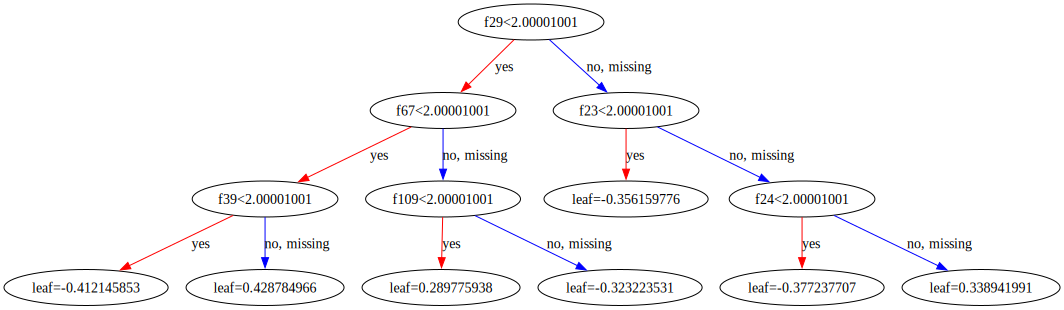

In [17]:
from matplotlib import pyplot
import graphviz
xgb.to_graphviz(model, num_trees=5)